In [77]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
# 폰트 설정
mpl.rc('font', family='Malgun Gothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)
# 그래프 크기 고정
plt.rcParams['figure.figsize'] = [15, 15]

font1 = {'family': 'Malgun Gothic', 'size': 24, 
         'color':  'Green'}
font2 = {'family': 'Malgun Gothic', 'size': 20, 'weight': 'bold',
         'color':  'blue'}
font3 = {'family': 'Malgun Gothic', 'size': 18, 
         'color':  'Green'}

from datetime import *
from dateutil.parser import parse

from tqdm import tqdm

import sqlite3
conn = sqlite3.connect('covid.db')
cur = conn.cursor()

In [62]:
# 연결 끊기
conn.close()

## 날짜 비교

In [64]:
today = datetime.today().date()
today

datetime.date(2020, 12, 23)

In [44]:
# db 날짜 형식 맞추기
db_today = today.strftime('%Y-%m-%d')
db_today

'2020-12-23'

In [51]:
# 맨 마지막행 날짜
sql = """ select * from all_info ORDER BY ROWID DESC LIMIT 1 """
cur.execute(sql, (db_today,))
row = cur.fetchone()
db_last_day = row[0]
print(db_last_day)
conn.commit()

2020-12-23


In [3]:
'2020-12-22'.replace('-','')

'20201222'

In [66]:
last_day = parse('2020-12-22').date()
last_day

datetime.date(2020, 12, 22)

In [60]:
# If 날짜가 같으면 안하고 아니면 하는거야 
# 반복문을 할 필요가 없지.. 라고 생각했다가 오늘 날짜가 안들어오니까...
# 이거 잘못생각하면 db에 같은 날짜 데이터가 여러번 들어갈수가 있다.
if today != last_day:
    print(1)
else:
    print('이미 최신정보로 업데이트되었습니다.')
    pass

이미 최신정보로 업데이트되었습니다.


In [73]:
# 당일날도 나옴
elapsed_count = (today - last_day).days
elapsed_series = pd.date_range(last_day+timedelta(1), periods= elapsed_count)
elapsed_series

DatetimeIndex(['2020-12-23'], dtype='datetime64[ns]', freq='D')

In [8]:
key_fd = open('../keys/gov_data_api_key.txt', mode='r')
govapi_key = key_fd.read(100)
key_fd.close()

In [56]:
# 원래 당일날은 안 나오지 않나?
date_list = [] ; city_list = [] ; death_toll_list = [] ; increase_list = [] ; case_list = [] ; local_list = [] ; inflow_list = [] ; isolation_list = [] ; release_list = [] ; per100k_list = []

corona_url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson"

for date in tqdm(elapsed_series):
    date =  date.strftime('%Y%m%d')

    url = f"{corona_url}?serviceKey={govapi_key}&pageNo=1&numOfRows=1&startCreateDt={date}&endCreateDt={date}"

    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'xml')

    # 날짜
    date = soup.select('createDt')
    # 도시
    city = soup.select('gubun')
    # 사망자 수
    death_toll = soup.select('deathCnt')
    # 전일대비 증감 수
    increase = soup.select('incDec')
    # 일일 확진자 수
    case = soup.select('defCnt')
    # 지역발생 수
    local = soup.select('localOccCnt')
    # 해외유입 수
    inflow = soup.select('overFlowCnt')
    # 격리중 확진자 수
    isolation = soup.select('isolIngCnt')
    # 일일 격리 해제 수
    release = soup.select('isolClearCnt')
    # 10만명당 발생률
    per100k = soup.select('qurRate')

    # 초반에 아직 해외유입이 없다거나, 사망자가 없다거나 해서 누락되는 데이터들이 있으므로 삼항연산자 혹은 오류처리를 해줘야 함
    for i in date:
        date_list.append(parse(i.text).date())
    for i in city:
        city_list.append(i.text)
    for i in death_toll:
        death_toll_list.append(int(i.text))
    for i in increase:
        increase_list.append(int(i.text))
    # 아무것도 없을 때에는 빈 리스트로 받아옴
    # 삼항연산자로 해결못함. i가 없음
    # try-except로도 해결못함. 값이 없을 뿐이지, 빈 리스트로 들어오긴 해서 오류가 아니기 때문임
    if len(case) != 0:
        for i in case:
            case_list.append(int(i.text))
    else:
        # 일자 length를 기준으로
        for i in range(len(date)):
            case_list.append(0)

    if len(local) != 0:
        for i in local:
            local_list.append(int(i.text))
    else:
        for i in range(len(date)):
            local_list.append(0)

    if len(inflow) != 0:
        for i in inflow:
            inflow_list.append(int(i.text))
    else:
        for i in range(len(date)):
            inflow_list.append(0)
  
    if len(isolation) != 0:
        for i in isolation:
            isolation_list.append(int(i.text))
    else:
        for i in range(len(date)):
            isolation_list.append(0)
    if len(isolation) != 0:
        for i in release:
            release_list.append(int(i.text))
    else:
        for i in range(len(date)):
            release_list.append(0)

    for i in per100k:
        try:
            per100k_list.append(float(i.text) if i.text.find('.') >= 0 else 0.00)
        # 51.13. 같은 이상한 값이 껴있음
        except:
            per100k_list.append(float(i.text[:-1]) if i.text.find('.') >= 0 else 0.00)

0it [00:00, ?it/s]


In [57]:
df = pd.DataFrame({
    '일자':date_list,
    '지역':city_list, '사망자':death_toll_list,
    '확진자':case_list, '전일대비':increase_list, '격리해제':release_list, 
    '격리중':isolation_list, '지역발생':local_list,'해외유입':inflow_list,
    '10만명당':per100k_list
})
df


,일자,지역,사망자,확진자,전일대비,격리해제,격리중,지역발생,해외유입,10만명당


- 생각해보니 csv파일에 넣을 필요 없이 바로 df를 db에 넣으면 됨

In [58]:
sql = """ insert into all_info values(?,?,?,?,?,?,?,?,?,?)
"""
for i in tqdm(range(len(df))):
    text_col = list(df.iloc[i,:2])
    for k in range(2,9):
        text_col.append(int(df.iloc[i,k]))
    text_col.append(float(df.iloc[i,-1]))
    params = text_col
    cur.execute(sql, params)
    conn.commit()

0it [00:00, ?it/s]


In [5]:
sql = '''create table all_info (
    date text not null,
    city text not null,
    death int default 0,
    increase int default 0,
    casenum int default 0,
    local int default 0,
    inflow int default 0,
    isolation int default 0, 
    release int default 0,
    per100k real default 0.00
);'''

cur.execute(sql)
conn.commit()

- 값 정제 <br>
int64는 int32로, float64는 float32로

In [6]:
text_col = list(all.iloc[0,:2])
text_col

['2020-03-04', '제주']

In [7]:
int_col = list(all.iloc[0,2:-1])
int_col

[0, 3, 0, 0, 0, 0, 0]

In [8]:
float_col = list(all.iloc[0,-1:])
float_col

[0.4]

In [9]:
text_col = list(all.iloc[0,:2])
for i in range(2,9):
    text_col.append(int(all.iloc[0,i]))
text_col.append(float(all.iloc[0,-1]))
text_col  

['2020-03-04', '제주', 0, 3, 0, 0, 0, 0, 0, 0.4]

- 값 추가

In [10]:
len(all)

5709

In [11]:
sql = """ insert into all_info values(?,?,?,?,?,?,?,?,?,?)
"""
for i in tqdm(range(len(all))):
    text_col = list(all.iloc[i,:2])
    for k in range(2,9):
        text_col.append(int(all.iloc[i,k]))
    text_col.append(float(all.iloc[i,-1]))
    params = text_col
    cur.execute(sql, params)
    conn.commit()

# 기존 일자별

In [63]:
daily = pd.read_csv('../static/data/covid/전국코로나일별.csv',sep=',',encoding='utf8')
daily.head(3)

,date,서울,부산,대구,인천,대전,광주,울산,세종,경기,강원,충북,충남,경북,경남,전북,전남,제주,합계
0,2020-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-03-02,10,3,469,0,0,0,3,0,7,8,1,13,67,4,1,0,0,586
2,2020-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- 테이블 만들기

In [ ]:
sql = '''create table daily_sido (
  date text not null primary key,
  seoul int default 0, busan int default 0, daegu int default 0,
  incheon int default 0, daejeon int default 0, gwangju int default 0,
  ulsan int default 0, sejong int default 0, gyeonggi int default 0,
  gangwon int default 0, chungbuk int default 0, chungnam int default 0,
  gyeongbuk int default 0, gyeongnam int default 0, jeonbuk int default 0,
  jeonnam int default 0, jeju int default 0, 
  gye int default 0);'''
cur.execute(sql)
conn.commit()

- 값 넣기

In [24]:
sql_insert = 'insert into daily_sido values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);'
for i in tqdm(range(len(daily))):
    params = [daily.iloc[i,0]]
    for k in range(1,19):
        params.append(int(daily.iloc[i,k]))
    cur.execute(sql_insert, params)
    conn.commit()

100%|██████████| 275/275 [00:01<00:00, 181.26it/s]


- 값 받아오기

In [5]:
def get_daily_data(date):
    sql = """ select * from daily_sido where date = ? """
    cur.execute(sql, (date,))
    rows = cur.fetchall()
    # print('db모듈쪽 rows', rows)
    return rows
    conn.commit()

print(get_daily_data('2020-11-12'))

[('2020-11-12', 53, 2, 3, 2, 2, 6, 1, 0, 35, 6, 1, 9, 1, 4, 0, 8, 1, 134)]


모든정보 table에서 날짜 받기

In [35]:
date = '2020-03-04'
sql = """ select * from all_info where date = ? """
cur.execute(sql, (date,))
rows = cur.fetchall()
for row in rows:
    print(row)
conn.commit()

('2020-03-04', '제주', 0, 3, 0, 0, 0, 0, 0, 0.4)
('2020-03-04', '경남', 0, 65, 1, 0, 0, 0, 0, 1.9)
('2020-03-04', '경북', 6, 774, 89, 0, 0, 0, 0, 29.1)
('2020-03-04', '전남', 0, 5, 0, 0, 0, 0, 0, 0.3)
('2020-03-04', '전북', 0, 7, 0, 0, 0, 0, 0, 0.4)
('2020-03-04', '충남', 0, 82, 1, 0, 0, 0, 0, 3.9)
('2020-03-04', '충북', 0, 11, 0, 0, 0, 0, 0, 0.7)
('2020-03-04', '강원', 0, 21, 1, 0, 0, 0, 0, 1.4)
('2020-03-04', '경기', 1, 101, 7, 0, 0, 0, 0, 0.8)
('2020-03-04', '세종', 0, 1, 0, 0, 0, 0, 0, 0.3)
('2020-03-04', '울산', 0, 23, 3, 0, 0, 0, 0, 0.0)
('2020-03-04', '대전', 0, 15, 1, 0, 0, 0, 0, 0.0)
('2020-03-04', '광주', 0, 13, 2, 0, 0, 0, 0, 0.9)
('2020-03-04', '인천', 0, 9, 2, 0, 0, 0, 0, 0.3)
('2020-03-04', '대구', 24, 4006, 405, 0, 0, 0, 0, 164.4)
('2020-03-04', '부산', 1, 93, 3, 0, 0, 0, 0, 2.7)
('2020-03-04', '서울', 0, 99, 1, 0, 0, 0, 0, 0.0)
('2020-03-04', '합계', 32, 5328, 516, 0, 0, 0, 0, 10.3)


In [42]:
def get_regional_data(date):
    sql = """ select * from all_info where date = ? """
    cur.execute(sql, (date,))
    rows = cur.fetchall()
    conn.commit()
    return rows

print(get_regional_data('2020-03-05'))

[('2020-03-05', '제주', 0, 4, 1, 0, 0, 0, 0, 0.6), ('2020-03-05', '경남', 0, 74, 9, 0, 0, 0, 0, 2.2), ('2020-03-05', '경북', 6, 861, 87, 0, 0, 0, 0, 32.3), ('2020-03-05', '전남', 0, 4, -1, 0, 0, 0, 0, 0.2), ('2020-03-05', '전북', 0, 7, 0, 0, 0, 0, 0, 0.4), ('2020-03-05', '충남', 0, 86, 4, 0, 0, 0, 0, 4.1), ('2020-03-05', '충북', 0, 12, 1, 0, 0, 0, 0, 0.8), ('2020-03-05', '강원', 0, 23, 2, 0, 0, 0, 0, 1.5), ('2020-03-05', '경기', 1, 110, 9, 0, 0, 0, 0, 0.8), ('2020-03-05', '세종', 0, 1, 0, 0, 0, 0, 0, 0.3), ('2020-03-05', '울산', 0, 23, 0, 0, 0, 0, 0, 2.0), ('2020-03-05', '대전', 0, 16, 1, 0, 0, 0, 0, 1.1), ('2020-03-05', '광주', 0, 14, 1, 0, 0, 0, 0, 1.0), ('2020-03-05', '인천', 0, 9, 0, 0, 0, 0, 0, 0.3), ('2020-03-05', '대구', 27, 4327, 321, 0, 0, 0, 0, 177.6), ('2020-03-05', '부산', 1, 92, -1, 0, 0, 0, 0, 2.7), ('2020-03-05', '서울', 0, 103, 4, 0, 0, 0, 0, 1.1), ('2020-03-05', '합계', 35, 5766, 438, 0, 0, 0, 0, 11.1)]


In [40]:
for row in rows:
    print(row[])

0
0
6
0
0
0
0
0
1
0
0
0
0
0
24
1
0
32


In [26]:
# cur.close()
# conn.close()

# 해외

In [3]:
world = pd.read_csv('../static/data/covid/해외.csv',sep=',',encoding='utf8')
del world['Unnamed: 0']
world.head(3)

,일자,대륙,국가,확진자,사망자,사망률
0,2020-03-16,기타,마요트,1,0,0.0
1,2020-03-16,기타,퀴라소,2,0,0.0
2,2020-03-16,기타,케이맨제도,1,0,0.0


In [4]:
# 어제 API에서 잘못 받아옴.
world[world.일자 == '2020-11-21']

,일자,대륙,국가,확진자,사망자,사망률
47355,2020-11-21,기타,기타지역 영토,194632,2371,1.218196
47356,2020-11-21,아프리카,레소토,2058,44,2.137998
47357,2020-11-21,아프리카,코모로,592,7,1.182432
47358,2020-11-21,아프리카,상투메프린시페,974,16,1.642710
47359,2020-11-21,아프리카,남수단,3016,59,1.956233
...,...,...,...,...,...,...
47539,2020-11-21,아시아,마카오,46,0,0.000000
47540,2020-11-21,아시아,대만,611,7,1.145663
47541,2020-11-21,아시아,홍콩,5517,108,1.957586
47542,2020-11-21,아시아,중국,86414,4634,5.362557


In [106]:
world.iloc[0,0]

'2020-11-21'

- 테이블 생성

In [5]:
sql = "drop table world"
cur.execute(sql)
conn.commit()

In [6]:
sql = '''create table world (
  date text not null,
  continent text not null,
  nation text not null,
  casenum int default 0, 
  death int default 0, 
  deathrate real default 0.00);'''
cur.execute(sql)
conn.commit()

- 값 넣기

In [62]:
text_col = list(world.iloc[0, 0:3])
text_col

['2020-11-21', '기타', '기타지역 영토']

In [63]:
int_col = list(world.iloc[0, 3:5])
int_col

[194632, 2371]

In [64]:
int_col = world.iloc[0, 4]
int_col

2371

In [65]:
float_col = world.iloc[0,-1]
float_col

1.2181963911

In [7]:
sql = 'insert into world values(?,?,?,?,?,?);'
for i in tqdm(range(len(world))):
    text_col = list(world.iloc[i,0:3])
    for k in range(3,5):
        text_col.append(int(world.iloc[i,k]))
    text_col.append(float(world.iloc[i,-1]))
    params = text_col
    cur.execute(sql, params)
    conn.commit()

100%|████████████████████████████████████████████████████████████████████████████| 53403/53403 [09:52<00:00, 90.10it/s]


In [115]:
def get_world_data(date):
    sql = """ select * from world where date = ? """
    cur.execute(sql, (date,))
    rows = cur.fetchall()
    return rows
    conn.commit()


print(get_world _data('2020-11-21'))
# print(get_world_data('2020-11-21'))

330734243), ('2020-11-21', '아프리카', '적도기니', 5121, 85, 1.6598320640000002), ('2020-11-21', '아프리카', '콩고', 5632, 93, 1.6512784090000001), ('2020-11-21', '아프리카', '중앙아프리카공화국', 4911, 63, 1.2828344532), ('2020-11-21', '아프리카', '나미비아', 13662, 141, 1.0320597276999999), ('2020-11-21', '아프리카', '케냐', 74145, 1330, 1.7937824533000002), ('2020-11-21', '아프리카', '기니', 12713, 75, 0.589947298), ('2020-11-21', '아프리카', '가나', 50631, 323, 0.6379490825), ('2020-11-21', '아프리카', '가봉', 9116, 59, 0.6472136902000001), ('2020-11-21', '아프리카', '에티오피아', 104427, 1607, 1.5388740459), ('2020-11-21', '아프리카', '수단', 15299, 1179, 7.706386038300001), ('2020-11-21', '아프리카', '코트디부아르', 21083, 129, 0.6118673813000001), ('2020-11-21', '아프리카', 'DR콩고', 12007, 323, 2.6900974431), ('2020-11-21', '아프리카', '부르키나파소', 2686, 68, 2.5316455696), ('2020-11-21', '아프리카', '토고', 2771, 63, 2.2735474556999997), ('2020-11-21', '아프리카', '남아프리카공화국', 759658, 20671, 2.7210929127999997), ('2020-11-21', '아프리카', '카메룬', 23528, 435, 1.8488609316), ('2020-11-21', 

# 성별연령별

In [68]:
demographic = pd.read_csv('../static/data/covid/성별연령별.csv',sep=',',encoding='utf8')
del demographic['Unnamed: 0']
demorgraphic.head(3)

,일자,구분,확진자,확진률,사망자,사망률
0,2020-04-02,0-9,112,1.14,0,0.0
1,2020-04-02,10-19,515,5.26,0,0.0
2,2020-04-02,20-29,2656,27.14,0,0.0


In [70]:
# 테이블 생성
sql = '''create table demographic (
  date text not null,
  demo text not null,
  casenum int default 0, 
  death int default 0, 
  caserate real default 0.00,
  deathrate real default 0.00);'''
cur.execute(sql)
conn.commit()

In [72]:
text_col = list(demographic.iloc[0, 0:2])
text_col

['2020-04-02', '0-9']

In [79]:
# 원래는 정수끼리, float끼리 모아놓음
int_col = list(demographic.iloc[0, 2:4])
int_col

[112, 1.14]

In [81]:
demographic.iloc[0, 4]

0

In [77]:
float_col = list(demographic.iloc[0, 4:])
float_col

[0, 0.0]

In [83]:
sql = 'insert into demographic values(?,?,?,?,?,?);'
for i in tqdm(range(len(demographic))):
    text_col = list(demographic.iloc[i,0:2])
    for k in range(2,4):
        text_col.append(int(demographic.iloc[i,k]))
    for h in range(4,6):
        text_col.append(float(demographic.iloc[i,h]))
    params = text_col
    cur.execute(sql, params)
    conn.commit()

100%|██████████| 2817/2817 [01:05<00:00, 42.74it/s]


In [94]:
def get_demorgraphic_data(date):
    sql = """ select * from demographic where date = ? """
    cur.execute(sql, (date,))
    rows = cur.fetchall()
    return rows
    conn.commit()

print(get_demographic_data('2020-04-02'))

[('2020-04-02', '0-9', 112, 1, 0.0, 0.0), ('2020-04-02', '10-19', 515, 5, 0.0, 0.0), ('2020-04-02', '20-29', 2656, 27, 0.0, 0.0), ('2020-04-02', '30-39', 1012, 10, 1.0, 0.62), ('2020-04-02', '40-49', 1312, 13, 1.0, 0.62), ('2020-04-02', '50-59', 1851, 18, 10.0, 6.17), ('2020-04-02', '60-69', 1235, 12, 22.0, 13.58), ('2020-04-02', '70-79', 651, 6, 46.0, 28.4), ('2020-04-02', '80 이상', 442, 4, 82.0, 50.62), ('2020-04-02', '여성', 5881, 60, 80.0, 49.38), ('2020-04-02', '남성', 3905, 39, 82.0, 50.62)]


In [72]:
date = '20201211'
corona_url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson"
total_date_list, total_city_list, total_posi_list = [], [], []

url = f"{corona_url}?serviceKey={govapi_key}&pageNo=1&numOfRows=1&startCreateDt={date}&endCreateDt={date}"
result = requests.get(url)
soup = BeautifulSoup(result.text, 'xml')
date_list_tmp = soup.select('createDt')
for date in date_list_tmp:
    total_date_list.append(parse(date.text).date())
# 도시 리스트
city_list_tmp = soup.select('gubun')
for city in city_list_tmp:
    total_city_list.append(city.text)
# 일일 확진자 발생 수
posi_list_tmp = soup.select('incDec')
for posi in posi_list_tmp:
    total_posi_list.append(int(posi.text))
korea = pd.DataFrame({
    # '일자': total_date_list,
    '지역': total_city_list,
    '확진자': total_posi_list
})


In [73]:
korea = korea.T
korea

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
지역,검역,제주,경남,경북,전남,전북,충남,충북,강원,경기,세종,울산,대전,광주,인천,대구,부산,서울,합계
확진자,7,5,12,3,4,7,10,20,11,229,0,47,10,3,37,6,26,252,689


In [90]:
all = pd.read_csv('../static/data/covid/전국 모든정보.csv',sep=',',encoding='utf8')
del all['Unnamed: 0']
all = all[['일자','지역','전일대비']]
all.head(3)

,일자,지역,전일대비
0,2020-03-04,제주,0
1,2020-03-04,경남,1
2,2020-03-04,경북,89


In [91]:
type(all.iloc[0,0])

str

In [92]:
all['일자'] = all.apply(lambda r: parse(r['일자']).date(), axis = 1)

In [93]:
type(all.iloc[0,0])
all.iloc[0,0]

datetime.date(2020, 3, 4)

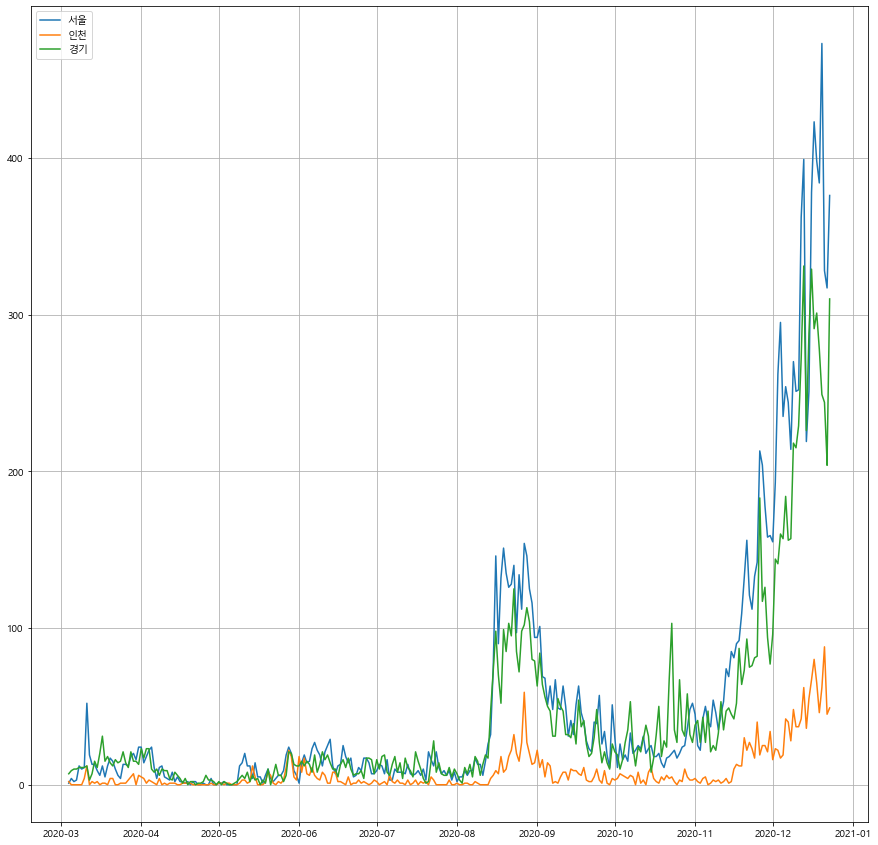

In [113]:
# 리스트로는 못 뽑고 반복문으로 뽑아야 함
city_list = ['서울','인천','경기']
for city in city_list:
    eachplot = all[all['지역']==city][['일자','전일대비']]
    plt.plot(eachplot['일자'], eachplot['전일대비'], label=city )
plt.legend()
plt.grid()
plt.show()

DB에서 가져오기

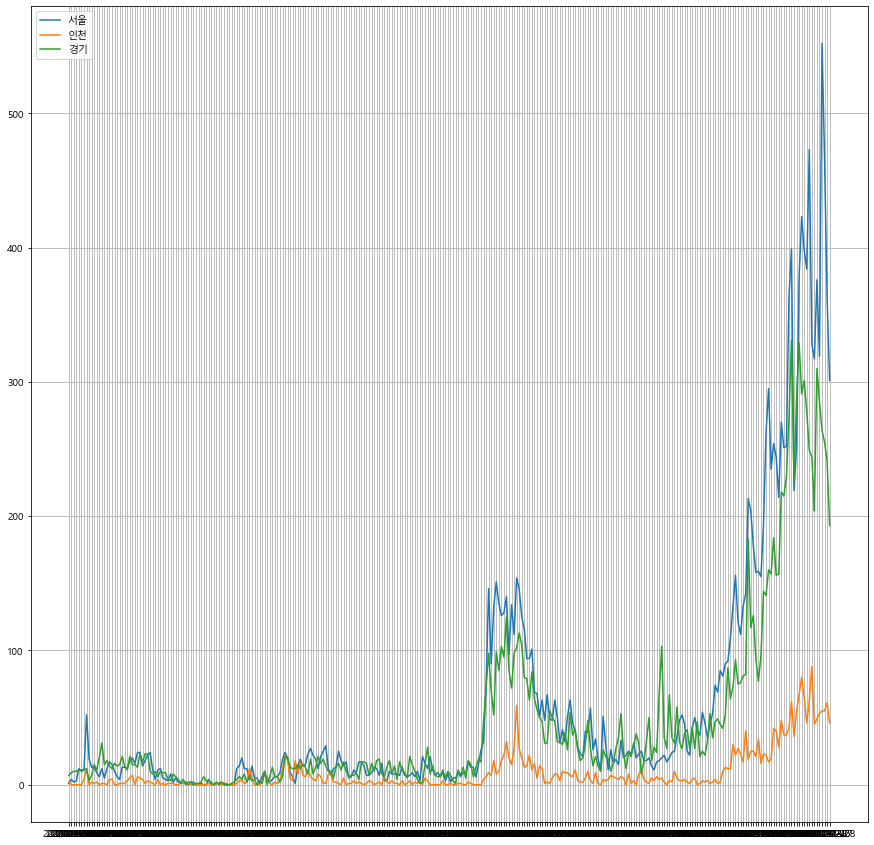

In [150]:
# 리스트로는 못 뽑고 반복문으로 뽑아야 함
city_list = ['서울','인천','경기']
for city in city_list:
    sql = """ select date,city,casenum from all_info where city = ? """
    cur.execute(sql, (city,) )
    rows = cur.fetchall()
    conn.commit()
    result = pd.DataFrame(rows, columns = ['일자','지역','전일대비'])


    plt.plot(result['일자'], result['전일대비'], label=city )
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 시계열로 바꾸면 제대로 나옴

In [148]:
sql = """ select date,city,casenum from all_info where city = '서울' """
cur.execute(sql)
rows = cur.fetchall()
conn.commit()

In [149]:
results = pd.DataFrame(rows, columns = ['일자','지역','전일대비'])
# results = results[[0,1,2]]
results

,일자,지역,전일대비
0,2020-03-04,서울,1
1,2020-03-05,서울,4
2,2020-03-06,서울,2
3,2020-03-07,서울,3
4,2020-03-08,서울,12
...,...,...,...
314,2020-12-24,서울,319
315,2020-12-25,서울,552
316,2020-12-26,서울,466
317,2020-12-27,서울,362
